### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

Загрузка необходимых библиотек:

In [25]:
import os
import psycopg2 as psycopg
import pandas as pd
import numpy as np
import optuna
from optuna.integration.mlflow import MLflowCallback
import joblib
import mlflow
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from sklearn.model_selection import cross_validate
from sklearn.metrics import max_error, r2_score, mean_absolute_percentage_error 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)
from autofeat import AutoFeatRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [3]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": "rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net", 
    "port": "6432",
    "dbname": "playground_mle_20240827_f58c68b5ea",
    "user": "mle_20240827_f58c68b5ea",
    "password": "4734c8048cac4fb782b922ef54ad31be",
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

TABLE_NAME = "clean_flats"

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
				
        data = cur.fetchall()

        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

print(f"Размер нашей таблицы: {df.shape[0]} строк; {df.shape[1]} столбцов")

Размер нашей таблицы: 19403 строк; 19 столбцов


In [3]:
# сделайте разделение изначального набора данных в этой ячейке
features = df.drop(columns="target")
target = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42
) # 0.25 x 0.8 = 0.2

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [80]:
# 2.1 Загрузка данных

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": "rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net", 
    "port": "6432",
    "dbname": "playground_mle_20240827_f58c68b5ea",
    "user": "mle_20240827_f58c68b5ea",
    "password": "4734c8048cac4fb782b922ef54ad31be",
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

TABLE_NAME = "clean_flats"

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
				
        data = cur.fetchall()

        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

print(f"Размер нашей таблицы: {df.shape[0]} строк; {df.shape[1]} столбцов")

Размер нашей таблицы: 19403 строк; 19 столбцов


In [7]:
# 2.2. Общий обзор датасета

In [7]:
# Настройка параметров отображения
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64 

sns.set_style("white")
sns.set_theme(style="whitegrid")

Директория в которую сохраним результаты EDA

In [22]:
ASSETS_DIR = "assets"

In [21]:
os.mkdir(ASSETS_DIR)

FileExistsError: [Errno 17] File exists: 'assets'

In [13]:
df.head()

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,target
0,4361,21054,2008,4,55.707535,37.758179,2.64,128,17,True,4,12.9,33.700001,2,False,False,60.299999,14500000.0,14500000.0
1,4362,19321,2004,4,55.583851,37.696922,2.70,438,16,True,1,9.0,45.000000,3,False,False,75.000000,13500000.0,13500000.0
2,4363,9926,1972,4,55.649277,37.519924,2.64,143,12,True,11,8.0,17.000000,1,False,False,32.099998,7500000.0,7500000.0
3,4364,21151,2008,4,55.990021,37.232895,2.65,107,14,True,9,9.3,18.900000,1,False,False,37.599998,8500000.0,8500000.0
4,4365,13491,1982,4,55.574734,37.668686,2.64,127,16,True,11,8.4,20.200001,1,False,False,36.900002,5700000.0,5700000.0


In [14]:
df.tail()

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,target
19398,19399,14084,1984,4,55.626541,37.720547,2.64,361,16,True,12,8.50,20.50,1,False,False,38.700001,6400000.0,6400000.0
19399,19400,13923,1983,4,55.798008,37.801689,2.64,270,17,True,10,10.00,46.00,3,False,False,75.000000,13990000.0,13990000.0
19400,19401,14501,1986,1,55.721687,37.610699,2.70,63,8,True,6,9.00,34.00,2,False,False,51.000000,13700000.0,13700000.0
19401,19402,18289,2001,4,55.884998,37.535870,2.65,118,17,True,9,12.00,29.40,2,False,False,56.000000,10800000.0,10800000.0
19402,19403,3162,1960,1,55.727470,37.768677,2.48,80,5,False,5,5.28,28.33,2,False,False,41.110001,7400000.0,7400000.0


In [16]:
df.describe()

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area
count,19403.000000,19403.000000,19403.000000,19403.000000,19403.000000,19403.000000,19403.00000,19403.000000,19403.000000,19403.000000,19403.000000,19403.000000,19403.000000,19403.000000
mean,9702.000000,11359.966500,1978.938669,3.385559,55.738647,37.609754,2.69591,160.927279,11.595990,5.941659,8.374290,31.049800,1.937742,50.778460
std,5601.307972,6563.838193,19.636173,1.651728,0.099415,0.139479,0.16031,101.282377,5.094044,4.115799,2.061625,11.010906,0.805186,16.050867
min,1.000000,105.000000,1910.000000,0.000000,55.466152,37.199657,2.30000,1.000000,1.000000,1.000000,2.500000,5.500000,1.000000,11.000000
25%,4851.500000,5811.500000,1965.000000,2.000000,55.664928,37.511444,2.64000,80.000000,8.000000,3.000000,6.300000,20.200001,1.000000,38.000000
50%,9702.000000,10858.000000,1974.000000,4.000000,55.740032,37.597668,2.64000,129.000000,12.000000,5.000000,8.500000,30.000000,2.000000,46.000000
75%,14552.500000,16501.500000,1996.000000,4.000000,55.815863,37.723318,2.74000,215.000000,16.000000,9.000000,10.000000,36.000000,2.000000,60.000000
max,19403.000000,24620.000000,2023.000000,6.000000,56.009346,37.946411,3.25000,485.000000,28.000000,18.000000,14.500000,71.599998,5.000000,116.699997


Проверка нулевых значений в данных

In [17]:
df.isnull().sum().sort_values(ascending=False)

id                   0
building_id          0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
target               0
dtype: int64

Поиск дубликатов

In [92]:
is_duplicated_id = df.duplicated(subset=['building_id'], keep=False)
print(sum(is_duplicated_id)) 

0


In [95]:
feature_cols = df.drop('building_id', axis=1).columns.to_list()
is_duplicated_features = df.duplicated(subset=feature_cols, keep=False)
print(len(df[is_duplicated_features]))

0


In [18]:
df.dtypes

id                     int64
building_id            int64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
floor                  int64
kitchen_area         float64
living_area          float64
rooms                  int64
is_apartment            bool
studio                  bool
total_area           float64
price                 object
target                object
dtype: object

In [19]:
# 2.3 Анализ признаков для модели

Построение графиков для анализа числовых признаков

In [49]:
aggregated_df = pd.DataFrame(df.groupby("building_type_int").agg({"total_area": 'mean'})).reset_index()

sorted_df = aggregated_df.sort_values("total_area", ascending=False)
sorted_df.reset_index(drop=True, inplace=True)
sorted_df["total_area"] = sorted_df["total_area"].astype(float)
sorted_df["total_area"] = sorted_df["total_area"].round(1)
sorted_df

,building_type_int,total_area
0,5,77.6
1,3,57.9
2,2,56.6
3,1,53.1
4,4,51.3
5,0,46.3
6,6,42.4


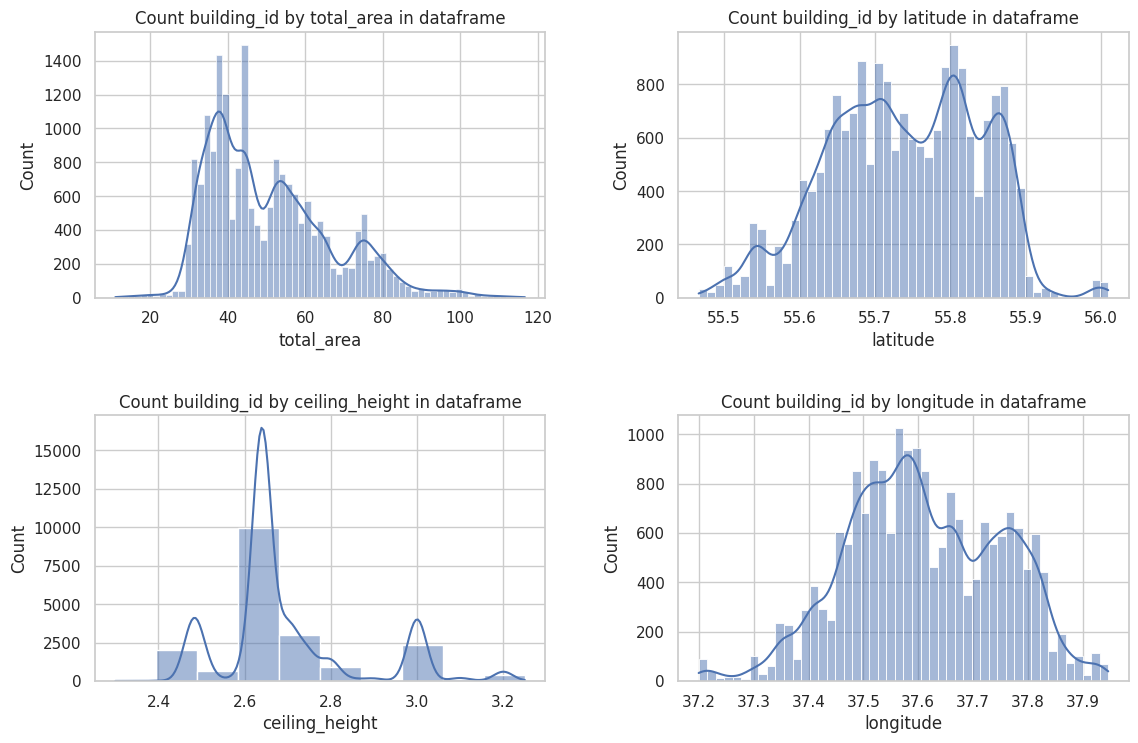

In [23]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12.5, 8.5, forward=True)
fig.tight_layout(pad=5)


x = "total_area"
y = "building_id"
sns.histplot(data=df, x=x, kde=True, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in dataframe')

x = "ceiling_height"
y = "building_id"
sns.histplot(data=df, x=x, kde=True, ax=axs[1, 0], binwidth=0.1)
axs[1, 0].set_title(f'Count {y} by {x} in dataframe')

x = "latitude"
y = "building_id"
sns.histplot(data=df, x=x, kde=True, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in dataframe')

x = "longitude"
y = "building_id"
sns.histplot(data=df, x=x, kde=True, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'num_features'))

Анализ категориальных признаков

In [58]:
aggregated_df = pd.DataFrame(df.groupby("building_type_int").agg({"building_id": 'count'})).reset_index()

sorted_df = aggregated_df.sort_values("building_id", ascending=False)
sorted_df.reset_index(drop=True, inplace=True)
sorted_df

,building_type_int,building_id
0,4,10936
1,1,4303
2,6,2526
3,2,1183
4,0,416
5,3,37
6,5,2


In [89]:
aggregated_df = pd.DataFrame(df.groupby("is_apartment").agg({"building_id": 'count'})).reset_index()
aggregated_df

,is_apartment,building_id
0,False,19300
1,True,103


In [107]:
aggregated_df = pd.DataFrame(df.groupby("studio").agg({"building_id": 'count'})).reset_index()
aggregated_df

,studio,building_id
0,False,19403


Построение графиков отображающих распределение категориальных признаков

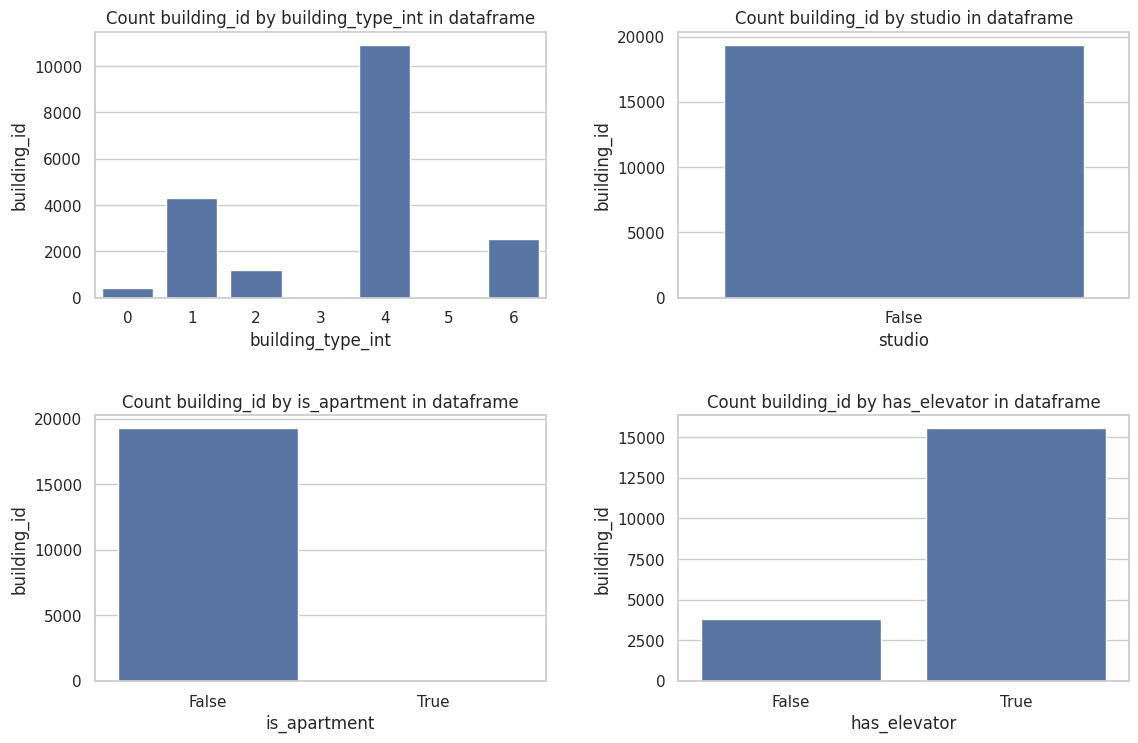

In [26]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12.5, 8.5, forward=True)
fig.tight_layout(pad=5)


x = "building_type_int"
y = "building_id"
func = "count"
agg_df = pd.DataFrame(df.groupby(x).agg({y: func})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in dataframe')

x = "is_apartment"
y = "building_id"
stat = "count"
agg_df = pd.DataFrame(df.groupby(x).agg({y: func})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in dataframe')

x = "studio"
y = "building_id"
stat = "count"
agg_df = pd.DataFrame(df.groupby(x).agg({y: func})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in dataframe')

x = "has_elevator"
y = "building_id"
stat = "count"
agg_df = pd.DataFrame(df.groupby(x).agg({y: func})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features'))

In [ ]:
# 2.4 Анализ целевой переменной

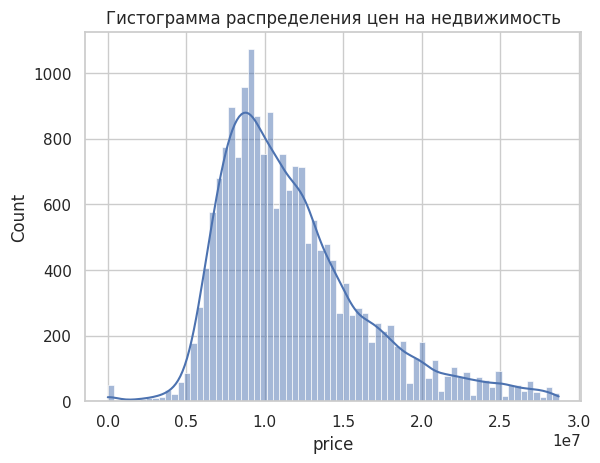

In [34]:
sns.histplot(data=df, x="price", kde=True)
plt.title('Гистограмма распределения цен на недвижимость')

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

In [ ]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [113]:
aggregated_df = pd.DataFrame(df.groupby("building_type_int").agg({"price": 'mean'})).reset_index()

sorted_df = aggregated_df.sort_values("price", ascending=False)
sorted_df.reset_index(drop=True, inplace=True)
sorted_df["price"] = sorted_df["price"].astype(float)
sorted_df["price"] = sorted_df["price"].round(1)
sorted_df

,building_type_int,price
0,2,14340205.5
1,1,13408713.5
2,3,13163386.5
3,4,11207349.9
4,0,10541136.3
5,6,10307383.5
6,5,8950000.0


Построение "Ящика с усами"

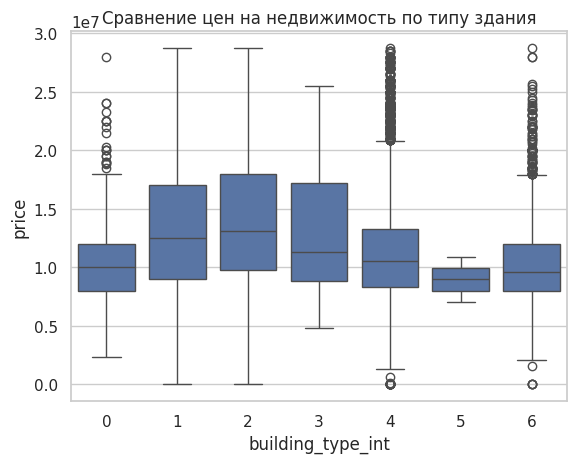

In [33]:
sns.boxplot(data=df, x="building_type_int", y="price")
plt.title('Сравнение цен на недвижимость по типу здания')

plt.savefig(os.path.join(ASSETS_DIR, 'target_by_building_type'))

Зависимость целевой переменной от года постройки сдания (price = target)

     build_year       price_mean price_median
0          1910       22660000.0   23450000.0
1          1911  15316666.666667   17500000.0
2          1912  15599666.333333   14900000.0
3          1913  22428166.666667   21000000.0
4          1914  15175508.571429   14300000.0
..          ...              ...          ...
104        2019  11664580.468085   10475000.0
105        2020  10763069.955556    9381430.0
106        2021       11625000.0   11050000.0
107        2022       14046470.5   13218941.0
108        2023       12900000.0   11200000.0

[109 rows x 3 columns]


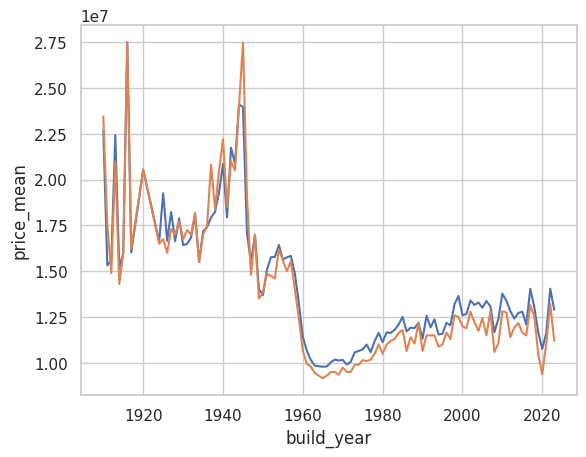

In [32]:
x = "build_year"

charges_columns = "price"

df[charges_columns].dropna(inplace=True)

stats = ["mean", "median"]

charges_monthly_agg = df[[x] + [charges_columns]].groupby([x]).agg(stats).reset_index()

charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()

charges_monthly_agg.columns = [x, "price_mean", "price_median"]

sns.lineplot(charges_monthly_agg, x=x, y="price_mean")
sns.lineplot(charges_monthly_agg, x=x, y="price_median")
print(charges_monthly_agg)

plt.savefig(os.path.join(ASSETS_DIR, 'target_by_build_year'))

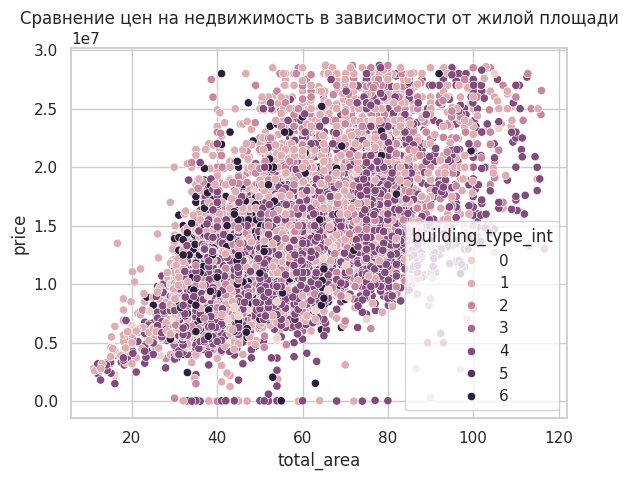

In [31]:
sns.scatterplot(data=df, x="total_area", y="price", hue="building_type_int")
plt.title('Сравнение цен на недвижимость в зависимости от жилой площади')

plt.savefig(os.path.join(ASSETS_DIR, 'target_by_total_area'))

In [ ]:
# 2.5 Выводы после EDA

1. Признак "studio" абсолютно не информативен, поскольку среди представленных квартир нету студий;
2. Среди почти 20 тысяч экземпляров данных всего два имеют "building_type_int" = 6;
3. Также среди представленных квартир очень мало апартаментов;
4. Цены на недвижимость имеют распределение близкое к нормальному;
5. Самые дорогие дома датой постройки до 1950 года, после 1960 года идет резкий спад.

In [ ]:
# 2.6 логирование артефактов в MLflow

In [35]:
EXPERIMENT_NAME = "flats_andreybikmulinvik"
RUN_NAME = "eda"


os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = 'YCAJEaw2pH6ASixkVD1V6OqIw'
os.environ["AWS_SECRET_ACCESS_KEY"] = 'YCNViAgYJAXurxFt-5ZAAH_ZQauS37kGWk4od83K'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [ ]:
# 3.1 ручная генерация признаков

Убираем неинформативные колонки и те, которые могут вызвать утечку

In [4]:
df.drop(columns=["price", "studio"], inplace=True)

Кодируем категориальные признаки

In [5]:
obj_df = df[["building_type_int", "is_apartment", "has_elevator"]]
cat_columns = ["building_type_int", "is_apartment", "has_elevator"]

encoder_oh = OneHotEncoder(categories='auto', sparse_output=False, drop="first", handle_unknown='ignore')

encoded_features = encoder_oh.fit_transform(df[cat_columns].to_numpy())

encoded_df = pd.DataFrame(encoded_features, columns=encoder_oh.get_feature_names_out(cat_columns))

obj_df = pd.concat([obj_df, encoded_df], axis=1)

obj_df.head(2)

,building_type_int,is_apartment,has_elevator,building_type_int_1,building_type_int_2,building_type_int_3,building_type_int_4,building_type_int_5,building_type_int_6,is_apartment_True,has_elevator_True
0,4,False,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4,False,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Применяем различные трансформеры к числовым признакам, коих в выборке представлено больше

In [6]:
num_df = df[["living_area", "kitchen_area", "total_area", "latitude", "ceiling_height", "longitude"]]

num_columns = ["living_area", "kitchen_area", "total_area", "latitude", "ceiling_height", "longitude"]

n_knots = 3
degree_spline = 4
n_quantiles=100
degree = 2
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None

#SplineTransformer
encoder_spl = SplineTransformer(n_knots=n_knots, degree=degree_spline)
encoded_features = encoder_spl.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features, 
    columns=encoder_spl.get_feature_names_out(num_columns)
)
num_df = pd.concat([num_df, encoded_df], axis=1)


# QuantileTransformer
encoder_q = QuantileTransformer(n_quantiles=n_quantiles)
encoded_features = encoder_q.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features, 
    columns=encoder_q.get_feature_names_out(num_columns)
)
encoded_df.columns = [col + f"_q_{n_quantiles}" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


# RobustScaler
encoder_rb = RobustScaler()
encoded_features = encoder_rb.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features, 
    columns=encoder_rb.get_feature_names_out(num_columns)
)
encoded_df.columns = [col + f"_robust" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


# PolynomialFeatures
encoder_pol = PolynomialFeatures(degree=degree)
encoded_features = encoder_pol.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features, 
    columns=encoder_pol.get_feature_names_out(num_columns)
)
encoded_df = encoded_df[encoded_df.columns[1 + len(num_columns):]]
num_df = pd.concat([num_df, encoded_df], axis=1)

# KBinsDiscretizer
encoder_kbd = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)
encoded_features = encoder_kbd.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features, 
    columns=encoder_kbd.get_feature_names_out(num_columns)
)
encoded_df.columns = [col + f"_bin" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


num_df.head(2)

,living_area,kitchen_area,total_area,latitude,ceiling_height,longitude,living_area_sp_0,living_area_sp_1,living_area_sp_2,living_area_sp_3,...,latitude longitude,ceiling_height^2,ceiling_height longitude,longitude^2,living_area_bin,kitchen_area_bin,total_area_bin,latitude_bin,ceiling_height_bin,longitude_bin
0,33.700001,12.9,60.299999,55.707535,2.64,37.758179,0.000019,0.071958,0.524859,0.381079,...,2103.415054,6.969601,99.681596,1425.680060,2.0,4.0,2.0,2.0,1.0,3.0
1,45.000000,9.0,75.000000,55.583851,2.70,37.696922,0.000000,0.017484,0.354707,0.543037,...,2095.340107,7.290000,101.781692,1421.057951,2.0,2.0,3.0,1.0,2.0,3.0


In [ ]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [7]:
numeric_transformer = ColumnTransformer(transformers=[
    ('spl', encoder_spl, num_columns),
    ('q', encoder_q, num_columns),
    ('rb', encoder_rb, num_columns),
    ('pol', encoder_pol, num_columns),
    ('kbd', encoder_kbd, num_columns)
]
)

categorical_transformer = Pipeline(steps=[
    ('encoder', encoder_oh)
]
)

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_columns),
    ('cat', categorical_transformer, cat_columns)
],
    n_jobs=-1
)

encoded_features = preprocessor.fit_transform(df)

transformed_df = pd.DataFrame(
    encoded_features, 
    columns=preprocessor.get_feature_names_out()
)

df = pd.concat([df, transformed_df], axis=1)
df.head(2)

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,...,num__kbd__ceiling_height,num__kbd__longitude,cat__building_type_int_1,cat__building_type_int_2,cat__building_type_int_3,cat__building_type_int_4,cat__building_type_int_5,cat__building_type_int_6,cat__is_apartment_True,cat__has_elevator_True
0,4361,21054,2008,4,55.707535,37.758179,2.64,128,17,True,...,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4362,19321,2004,4,55.583851,37.696922,2.70,438,16,True,...,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Отобразим получившийся преобразователь данных

In [94]:
preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('num',
                                 ColumnTransformer(transformers=[('spl',
                                                                  SplineTransformer(degree=4,
                                                                                    n_knots=3),
                                                                  ['living_area',
                                                                   'kitchen_area',
                                                                   'total_area',
                                                                   'latitude',
                                                                   'ceiling_height',
                                                                   'longitude']),
                                                                 ('q',
                                                                  QuantileTransformer(n_quantiles=100),
                                                                  ['living_area',
                                                                   'kitchen_area',
                                                                   'total_area',
                                                                   'latitude',
                                                                   'ceiling_height',
                                                                   'longitude']),
                                                                 ('rb',
                                                                  Robust...
                                                                                   subsample=None),
                                                                  ['living_area',
                                                                   'kitchen_area',
                                                                   'total_area',
                                                                   'latitude',
                                                                   'ceiling_height',
                                                                   'longitude'])]),
                                 ['living_area', 'kitchen_area', 'total_area',
                                  'latitude', 'ceiling_height', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['building_type_int', 'is_apartment',
                                  'has_elevator'])])

In [ ]:
# 3.3 автоматическая генерация признаков

Разбиваем выборку на тренировочную/тестовую

In [259]:
cat_features = ["building_type_int", "is_apartment", "has_elevator"]
num_features = [
    "living_area",
    "kitchen_area",
    "total_area",
    "latitude",
    "ceiling_height",
    "longitude"
]

features = cat_features + num_features
target = "target"


X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=0.2,
    random_state=42
)

Автогенерация признаков через AutoFeatRegressor

In [260]:
transformations = ("1/", "log", "abs", "sqrt")

afr = AutoFeatRegressor(categorical_cols=cat_features, transformations=transformations, feateng_steps=1, n_jobs=-1) 

X_train_features = afr.fit_transform(X_train, y_train)
X_test_features = afr.transform(X_test)

X_test_features

,living_area,kitchen_area,total_area,latitude,ceiling_height,longitude,cat_building_type_int_0.0,cat_building_type_int_1.0,cat_building_type_int_2.0,cat_building_type_int_3.0,cat_building_type_int_4.0,cat_building_type_int_6.0,cat_is_apartment_0.0,cat_is_apartment_1.0,cat_has_elevator_0.0,cat_has_elevator_1.0
0,20.799999,8.60,38.900002,55.889355,2.64,37.622620,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,31.000000,10.00,56.599998,55.877144,2.65,37.543804,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,34.270000,10.02,59.099998,55.649506,2.66,37.387848,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,45.000000,10.00,70.000000,55.888508,2.64,37.666046,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,39.000000,9.50,75.500000,55.717010,3.00,37.623692,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,35.642426,8.50,36.599998,55.631523,2.64,37.516376,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3877,45.299999,6.70,63.200001,55.879314,2.50,37.690975,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3878,27.000000,5.50,42.000000,55.806618,3.00,37.530884,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3879,32.000000,10.00,58.299999,55.658962,2.64,37.761105,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# 3.4 обучение новой версии модели

Разбиваем выборку на тренировочную/тестовую/валидационную

In [8]:
features = df.drop(columns="target").columns
target = "target"

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42
)

Определяем и обучаем модель

In [159]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [160]:
prediction = model.predict(X_val)

Определяем метрики и производим предварительную оценку модели на валидационной выборке

In [172]:
metrics = {}

max_err = max_error(y_val, prediction)
r2 = r2_score(y_val, prediction)
percentage_error = mean_absolute_percentage_error(y_val, prediction)

metrics["max_error"] = max_err
metrics["r2"] = r2
metrics["neg_mean_absolute_percentage_error"] = percentage_error

In [173]:
print(metrics)

{'max_error': 25196111.421592712, 'r2': -0.6508431620485513, 'neg_mean_absolute_percentage_error': 40.332792275652636}


Проводим кросс-валидацию на тестовой выборке

In [179]:
cv_res = cross_validate(
        model,
        X_test,
        y_test,
        cv=5,
        n_jobs=-1,
        scoring=list(metrics.keys())
        )

for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)

cv_res

{'fit_time': 0.045,
 'score_time': 0.006,
 'test_max_error': -13296031.872,
 'test_r2': 0.617,
 'test_neg_mean_absolute_percentage_error': -0.577}

Сохраняем производительность модели

In [180]:
metrics = cv_res

In [ ]:
# 3.5 логирование артефактов в MLflow

Логируем предобработку данных

In [186]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "flats_andreybikmulinvik"
RUN_NAME = "preprocessing"
REGISTRY_MODEL_NAME = "model_flats_andreybikmulinvik"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = "YCAJEaw2pH6ASixkVD1V6OqIw"
os.environ["AWS_SECRET_ACCESS_KEY"] = "YCNViAgYJAXurxFt-5ZAAH_ZQauS37kGWk4od83K"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(preprocessor, "column_transformer")

2024/10/22 22:52:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Логируем автоматический генератор признаков

In [262]:
RUN_NAME = "afr"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(afr, "afr")

Логируем обученную модель

In [188]:
RUN_NAME = "model_1_preprocessing"


pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(metrics)
    model_info = mlflow.sklearn.log_model( 
        sk_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

/home/mle-user/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
2024/10/22 22:52:40 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifa

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [ ]:
# 4.1 Отбор признаков при помощи метода номер 1

Определяем клиет MLflow

In [190]:
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)

Выгружаем получившуюся в предыдущем этапе модель

In [191]:
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

run = client.get_run("4a99653eff764c6d91421996678fc4f6")
artifact_uri = run.info.artifact_uri

mlflow.artifacts.download_artifacts(artifact_uri, dst_path="./artifacts_local")

'/home/mle-user/mle-project-sprint-2-v001/model_improvement/artifacts_local/artifacts'

In [264]:
estimator = joblib.load('artifacts_local/artifacts/models/model.pkl')

Определяем первый метод отбора признаков с (Оберточный метод отбора признаков с добавлением к пустому набору наиболее значимых для модели) 

In [199]:
sfs = SFS(estimator,
    k_features=10,       
    forward=True,      
    floating=False,     
    scoring='r2', 
    cv=3,               
    n_jobs=-1
)

Запускаем алгоритм

In [200]:
sfs = sfs.fit(X_train, y_train)

Выведем отобранные признаки

In [215]:
top_sfs = sfs.k_feature_names_
print(top_sfs)

('building_id', 'floor', 'num__spl__latitude_sp_0', 'num__spl__latitude_sp_1', 'num__spl__latitude_sp_4', 'num__spl__latitude_sp_5', 'num__spl__longitude_sp_0', 'num__spl__longitude_sp_1', 'num__spl__longitude_sp_4', 'num__pol__total_area ceiling_height')


In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

Последовательный отбор признаков с отсеиванием наименее значимых

In [205]:
sbs = SFS(estimator,
    k_features=96,       
    forward=False,      
    floating=False,     
    scoring='r2', 
    cv=3,               
    n_jobs=-1
)

In [207]:
sbs = sbs.fit(X_train, y_train)

In [214]:
top_sbs = sbs.k_feature_names_
print(top_sbs)

('id', 'building_id', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area', 'living_area', 'is_apartment', 'total_area', 'num__spl__living_area_sp_0', 'num__spl__living_area_sp_1', 'num__spl__living_area_sp_2', 'num__spl__living_area_sp_3', 'num__spl__living_area_sp_4', 'num__spl__living_area_sp_5', 'num__spl__kitchen_area_sp_0', 'num__spl__kitchen_area_sp_1', 'num__spl__kitchen_area_sp_2', 'num__spl__kitchen_area_sp_3', 'num__spl__kitchen_area_sp_4', 'num__spl__kitchen_area_sp_5', 'num__spl__total_area_sp_0', 'num__spl__total_area_sp_1', 'num__spl__total_area_sp_2', 'num__spl__total_area_sp_3', 'num__spl__total_area_sp_4', 'num__spl__total_area_sp_5', 'num__spl__latitude_sp_0', 'num__spl__latitude_sp_1', 'num__spl__latitude_sp_2', 'num__spl__latitude_sp_3', 'num__spl__latitude_sp_4', 'num__spl__latitude_sp_5', 'num__spl__ceiling_height_sp_0', 'num__spl__ceiling_height_sp_1', 'num__spl__ceiling_height_sp_2', 'num__spl__ceilin

In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

Выведем метрики качества предсказания модели для обоих методов

In [216]:

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
0.6146078698668509

Sequential Backward Selection
CV Score:
0.6272966076399213


Формируем таблицу с результатами отбора

In [209]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [218]:
FS_ASSETS = "fs_assets"

os.mkdir(FS_ASSETS)

Сохраняем данные для воспроизводимости результатов

In [219]:
sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

Восстановление данных

In [9]:
sfs_df = pd.read_csv('fs_assets/sfs.csv', delimiter=',')
sbs_df = pd.read_csv('fs_assets/sbs.csv', delimiter=',')

In [38]:
sfs_df["feature_names"][9]

"('building_id', 'floor', 'num__spl__latitude_sp_0', 'num__spl__latitude_sp_1', 'num__spl__latitude_sp_4', 'num__spl__latitude_sp_5', 'num__spl__longitude_sp_0', 'num__spl__longitude_sp_1', 'num__spl__longitude_sp_4', 'num__pol__total_area ceiling_height')"

In [39]:
sbs_df["feature_names"][10]

"('id', 'building_id', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area', 'living_area', 'is_apartment', 'total_area', 'num__spl__living_area_sp_0', 'num__spl__living_area_sp_1', 'num__spl__living_area_sp_2', 'num__spl__living_area_sp_3', 'num__spl__living_area_sp_4', 'num__spl__living_area_sp_5', 'num__spl__kitchen_area_sp_0', 'num__spl__kitchen_area_sp_1', 'num__spl__kitchen_area_sp_2', 'num__spl__kitchen_area_sp_3', 'num__spl__kitchen_area_sp_4', 'num__spl__kitchen_area_sp_5', 'num__spl__total_area_sp_0', 'num__spl__total_area_sp_1', 'num__spl__total_area_sp_2', 'num__spl__total_area_sp_3', 'num__spl__total_area_sp_4', 'num__spl__total_area_sp_5', 'num__spl__latitude_sp_0', 'num__spl__latitude_sp_1', 'num__spl__latitude_sp_2', 'num__spl__latitude_sp_3', 'num__spl__latitude_sp_4', 'num__spl__latitude_sp_5', 'num__spl__ceiling_height_sp_0', 'num__spl__ceiling_height_sp_1', 'num__spl__ceiling_height_sp_2', 'num__spl__ceili

In [10]:
top_sfs = ['building_id', 'floor', 'num__spl__latitude_sp_0', 'num__spl__latitude_sp_1', 'num__spl__latitude_sp_4', 'num__spl__latitude_sp_5', 'num__spl__longitude_sp_0', 'num__spl__longitude_sp_1', 'num__spl__longitude_sp_4', 'num__pol__total_area ceiling_height']
top_sbs = ['id', 'building_id', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area', 'living_area', 'is_apartment', 'total_area', 'num__spl__living_area_sp_0', 'num__spl__living_area_sp_1', 'num__spl__living_area_sp_2', 'num__spl__living_area_sp_3', 'num__spl__living_area_sp_4', 'num__spl__living_area_sp_5', 'num__spl__kitchen_area_sp_0', 'num__spl__kitchen_area_sp_1', 'num__spl__kitchen_area_sp_2', 'num__spl__kitchen_area_sp_3', 'num__spl__kitchen_area_sp_4', 'num__spl__kitchen_area_sp_5', 'num__spl__total_area_sp_0', 'num__spl__total_area_sp_1', 'num__spl__total_area_sp_2', 'num__spl__total_area_sp_3', 'num__spl__total_area_sp_4', 'num__spl__total_area_sp_5', 'num__spl__latitude_sp_0', 'num__spl__latitude_sp_1', 'num__spl__latitude_sp_2', 'num__spl__latitude_sp_3', 'num__spl__latitude_sp_4', 'num__spl__latitude_sp_5', 'num__spl__ceiling_height_sp_0', 'num__spl__ceiling_height_sp_1', 'num__spl__ceiling_height_sp_2', 'num__spl__ceiling_height_sp_3', 'num__spl__ceiling_height_sp_4', 'num__spl__ceiling_height_sp_5', 'num__spl__longitude_sp_0', 'num__spl__longitude_sp_1', 'num__spl__longitude_sp_2', 'num__spl__longitude_sp_3', 'num__spl__longitude_sp_4', 'num__spl__longitude_sp_5', 'num__q__kitchen_area', 'num__q__total_area', 'num__q__ceiling_height', 'num__q__longitude', 'num__rb__living_area', 'num__rb__kitchen_area', 'num__rb__total_area', 'num__rb__latitude', 'num__rb__ceiling_height', 'num__rb__longitude', 'num__pol__1', 'num__pol__living_area', 'num__pol__kitchen_area', 'num__pol__total_area', 'num__pol__latitude', 'num__pol__ceiling_height', 'num__pol__longitude', 'num__pol__living_area^2', 'num__pol__living_area kitchen_area', 'num__pol__living_area total_area', 'num__pol__living_area latitude', 'num__pol__living_area ceiling_height', 'num__pol__kitchen_area^2', 'num__pol__kitchen_area total_area', 'num__pol__kitchen_area latitude', 'num__pol__kitchen_area ceiling_height', 'num__pol__total_area^2', 'num__pol__total_area latitude', 'num__pol__total_area ceiling_height', 'num__pol__total_area longitude', 'num__pol__latitude^2', 'num__pol__latitude ceiling_height', 'num__pol__latitude longitude', 'num__pol__ceiling_height^2', 'num__pol__ceiling_height longitude', 'num__pol__longitude^2', 'num__kbd__living_area', 'num__kbd__kitchen_area', 'num__kbd__total_area', 'num__kbd__latitude', 'num__kbd__longitude', 'cat__building_type_int_1', 'cat__building_type_int_2', 'cat__building_type_int_3', 'cat__building_type_int_4', 'cat__is_apartment_True', 'cat__has_elevator_True']

График производительности модели на основе SequentialFeatureSelector (Forward)

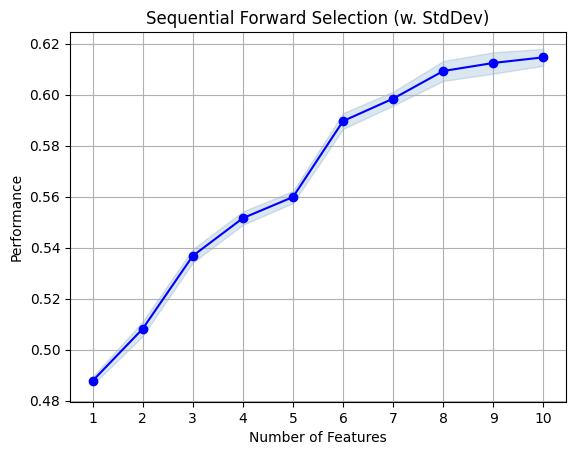

In [223]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()


plt.savefig("fs_assets/sfs.png") 

График производительности модели на основе SequentialFeatureSelector (Backward)

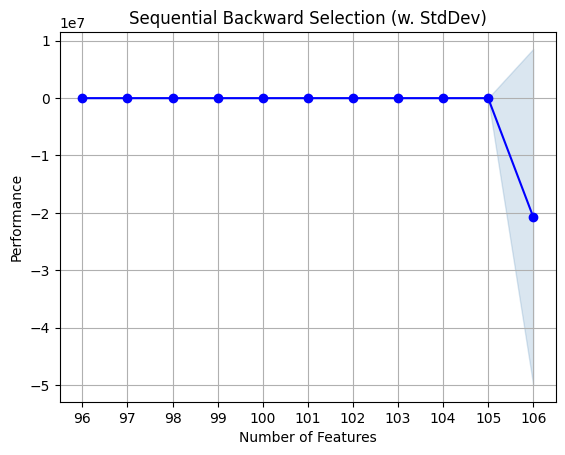

In [224]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()


plt.savefig("fs_assets/sbs.png") 

Определим признаки пересекающиеся у обоих алгоритмов и объединенный набор признаков

In [11]:
interc_features = list(set(top_sbs) & set(top_sfs))  
union_features = list(set(top_sbs) | set(top_sfs))

In [ ]:
# 4.4 Обучение новой версии модели

Обучаем модель на пересекшихся признаках и оцениваем ее качество

In [265]:
estimator.fit(X_train[interc_features], y_train)

LinearRegression()

In [266]:
prediction = estimator.predict(X_val[interc_features])

In [268]:
metrics = {}

max_err = max_error(y_val, prediction)
r2 = r2_score(y_val, prediction)
percentage_error = mean_absolute_percentage_error(y_val, prediction)

metrics["max_error"] = max_err
metrics["r2"] = r2
metrics["neg_mean_absolute_percentage_error"] = percentage_error

print(metrics)

{'max_error': 19912437.440345883, 'r2': 0.6064898979612507, 'neg_mean_absolute_percentage_error': 43.12795692270883}


Обучаем модель на объединенных признаках и оцениваем ее качество

In [269]:
estimator.fit(X_train[union_features], y_train)

LinearRegression()

In [270]:
prediction = estimator.predict(X_val[union_features])

In [271]:
metrics = {}

max_err = max_error(y_val, prediction)
r2 = r2_score(y_val, prediction)
percentage_error = mean_absolute_percentage_error(y_val, prediction)

metrics["max_error"] = max_err
metrics["r2"] = r2
metrics["neg_mean_absolute_percentage_error"] = percentage_error

print(metrics)

{'max_error': 18707912.27106476, 'r2': 0.6201560933974114, 'neg_mean_absolute_percentage_error': 43.75972252168427}


Выбираем interc_features, дающее схожие результаты при меньшем числе признаков

In [12]:
X_train = X_train[interc_features]
X_val = X_val[interc_features]
X_test = X_test[interc_features]

Обучаем новую версию модели и проводим кросс-валидацию для оценки ее производительности

In [273]:
estimator.fit(X_train, y_train)

LinearRegression()

In [276]:
prediction = estimator.predict(X_val)

In [274]:
cv_res = cross_validate(
        estimator,
        X_test,
        y_test,
        cv=5,
        n_jobs=-1,
        scoring=list(metrics.keys())
        )

for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)

metrics = cv_res
metrics

{'fit_time': 0.009,
 'score_time': 0.008,
 'test_max_error': -13904635.661,
 'test_r2': 0.608,
 'test_neg_mean_absolute_percentage_error': -0.61}

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

Логируем результаты отбора признаков

In [275]:
RUN_NAME = "feature_selection"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") # tracking uri
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") # registry uri


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

Логируем новую версию модели

In [277]:
RUN_NAME = "model_2_FS"


pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(metrics)
    model_info = mlflow.sklearn.log_model( 
        sk_model=estimator,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

/home/mle-user/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'model_flats_andreybikmulinvik' already exists. Creating a new version of this model...
2024/10/23 00:31:3

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

Проводим подбор гиперпараметров на основе байесовского подхода

В качестве модели возьмем линейную регрессию с коэффициентом регуляризации - Lasso, для добавления варьируемых параметров и возможности улучшить качество предсказания модели

Определяем функцию objective со словарем необходимых параметров модели и кросс-валидацией для оценки качества подбора, а также фиксируем генератор псевдослучайных чисел для воспроизводимости эксперимента

In [13]:
def objective(trial: optuna.Trial) -> float:
    param = {
    'alpha': trial.suggest_float("alpha", 0.001, 1000, log=True),
    'tol': trial.suggest_float("tol", 0.00001, 0.001, step=0.0001),
    'selection': trial.suggest_categorical('selection', ['cyclic', 'random']),
    'random_state': 42
 }
    model = Lasso(**param)

    cv_res = cross_validate(
            model,
            X_val,
            y_val,
            cv=3,
            n_jobs=-1,
            scoring=["max_error", "r2", "neg_mean_absolute_percentage_error"]
            )

    for key, value in cv_res.items():
        cv_res[key] = value.mean()



    max_err = cv_res["test_max_error"]
    r2 = cv_res["test_r2"]
    percentage_error = cv_res["test_neg_mean_absolute_percentage_error"]
    
		

    return percentage_error

Запускаем алгоритм отбора (maximize для neg_MAPE, число испытаний 100)

In [14]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)
best_params = study.best_params

[I 2024-10-23 16:24:40,261] A new study created in memory with name: no-name-da3acece-e96d-46cd-b887-c5ce194a3397
/home/mle-user/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [1e-05, 0.001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [1e-05, 0.00091].
  warnings.warn(
[I 2024-10-23 16:24:40,428] Trial 0 finished with value: -43.23781188220215 and parameters: {'alpha': 0.19284370227173298, 'tol': 0.0006100000000000001, 'selection': 'random'}. Best is trial 0 with value: -43.23781188220215.
[I 2024-10-23 16:24:40,485] Trial 1 finished with value: -43.25611942381022 and parameters: {'alpha': 663.2858958875179, 'tol': 0.00071, 'selection': 'cyclic'}. Best is trial 0 with value: -43.23781188220215.
[I 2024-10-23 16:24:40,543] Trial 2 finished with value: -43.22788691347859 and parameters: {'alpha': 523.4176615391508, 'tol': 0.0004100000000

Выводим параметры модели, показавшие наилучшую производительность

In [46]:
best_params

{'alpha': 958.3797564947156, 'tol': 0.00091, 'selection': 'cyclic'}

In [54]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

Подбор параметров при помощи случайного поиска

In [15]:
model = Lasso(random_state=42)

Формуируем диапазон варьирования параметров

In [16]:
param_distributions = {
    'alpha': [x for x in np.linspace(0.1, 100, 1000)],
    'tol': [x for x in np.linspace(0.00001, 0.001, 100)],
    'selection': ['cyclic', 'random']
}

Определяем и запускаем алгоритм подбора

In [17]:
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=100, cv=5, scoring='neg_mean_absolute_percentage_error', random_state=42, n_jobs=-1)
random_search.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=Lasso(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.30000000000000004,
                                                  0.4, 0.5, 0.6,
                                                  0.7000000000000001, 0.8, 0.9,
                                                  1.0, 1.1, 1.2000000000000002,
                                                  1.3000000000000003,
                                                  1.4000000000000001,
                                                  1.5000000000000002, 1.6,
                                                  1.7000000000000002,
                                                  1.8000000000000003,
                                                  1.9000000000000001, 2.0, 2.1,
                                                  2.2, 2.3000000000000003...
                                                0.00015999999999999999,
                                                0.00016999999999999999,
                                                0.00017999999999999998,
                                                0.00018999999999999998,
                                                0.00019999999999999998,
                                                0.00020999999999999998,
                                                0.00021999999999999998,
                                                0.00022999999999999998,
                                                0.00023999999999999998, 0.00025,
                                                0.00026000000000000003, 0.00027,
                                                0.00028, 0.00029,
                                                0.00030000000000000003, ...]},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error')

In [29]:
best_params = random_search.best_params_
best_params

{'tol': 0.0007, 'selection': 'random', 'alpha': 0.4}

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

Выводим оценки качества моделей, обученных на отобранных двумя способами параметрах

In [18]:
best_model_bayes = Lasso(random_state=42, **best_params)
best_model_bayes.fit(X_train, y_train)

test_score = best_model_bayes.score(X_val, y_val)
test_score

0.583176438641603

In [19]:
best_model_random = random_search.best_estimator_
best_model_random.fit(X_train, y_train)

test_score = best_model_random.score(X_val, y_val)
test_score

0.6064869497362462

Определяем модель, показатели качества которой - выше

In [20]:
model = best_model_bayes
best_params

{'alpha': 962.044872573948,
 'tol': 0.00031000000000000005,
 'selection': 'cyclic'}

In [ ]:
# 5.4 Обуение финальной версии модели

In [21]:
model.fit(X_train, y_train)

Lasso(alpha=962.044872573948, random_state=42, tol=0.00031000000000000005)

In [22]:
prediction = model.predict(X_test)

In [23]:
metrics = {}

max_err = max_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
percentage_error = mean_absolute_percentage_error(y_test, prediction)

metrics["max_error"] = max_err
metrics["r2"] = r2
metrics["neg_mean_absolute_percentage_error"] = percentage_error

print(metrics)

{'max_error': 16457949.123873077, 'r2': 0.5866612631451544, 'neg_mean_absolute_percentage_error': 0.6008394059292195}


In [ ]:
# 5.5 Логирование артефактов в MLflow

Логируем объект study с приминением MLflowCallback

In [28]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "flats_andreybikmulinvik"
RUN_NAME = "bayesian_search"
REGISTRY_MODEL_NAME = "model_flats_andreybikmulinvik"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = "YCAJEaw2pH6ASixkVD1V6OqIw"
os.environ["AWS_SECRET_ACCESS_KEY"] = "YCNViAgYJAXurxFt-5ZAAH_ZQauS37kGWk4od83K"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
    

pip_requirements = "../requirements.txt"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    


    mlflc = MLflowCallback(
        tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
        metric_name="neg_mean_absolute_percentage_error",
        create_experiment=False,
        mlflow_kwargs={'experiment_id': experiment_id, "tags": {MLFLOW_PARENT_RUN_ID: run_id}, "nested": True}
    )

    study = optuna.create_study(direction='maximize', study_name="flats_model", storage="sqlite:///local.study.db", load_if_exists=True, sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=30, callbacks=[mlflc])
    best_params = study.best_params

    
    mlflow.log_params(best_params)
    model_info = mlflow.sklearn.log_model( 
        sk_model=study,
        artifact_path="study",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        await_registration_for=60
		)

/tmp/ipykernel_2195/203074646.py:25: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2024-10-23 16:40:21,978] Using an existing study with name 'flats_model' instead of creating a new one.
/home/mle-user/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [1e-05, 0.001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [1e-05, 0.00091].
  warnings.warn(
[I 2024-10-23 16:40:23,501] Trial 30 finished with value: -43.23630132325314 and parameters: {'alpha': 50.40599793653805, 'tol': 0.00031000000000000005, 'selection': 'random'}. Best is trial 15 with value: -43.175814496317166.
[I 2024-10-23 16:40:23,808] Trial 31 finished with value: -43.186164654119814 and parameters: {'alpha': 905.2874205951789, 'tol': 1e-05, 'selection': 'random'}. Best is trial 15

Логируем случайный поиск

In [31]:
RUN_NAME = "random_search"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    best_params = random_search.best_params_
    
    mlflow.log_params(best_params)
    cv_info = mlflow.sklearn.log_model(random_search, artifact_path='random_search')

Логируем финальную версию модели

In [32]:
RUN_NAME = "model_3_hyperparam"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(metrics)
    model_info = mlflow.sklearn.log_model( 
        sk_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

/home/mle-user/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'model_flats_andreybikmulinvik' already exists. Creating a new version of this model...
2024/10/23 16:55:5

Переведем последнюю версию модели в стадию "Production"

In [33]:
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)

In [34]:
client.transition_model_version_stage('model_flats_andreybikmulinvik', 13, "production")

<ModelVersion: aliases=[], creation_timestamp=1729702553553, current_stage='Production', description='', last_updated_timestamp=1729702721254, name='model_flats_andreybikmulinvik', run_id='4af15702b425432bab5b045b75126b85', run_link='', source='s3://s3-student-mle-20240827-f58c68b5ea/3/4af15702b425432bab5b045b75126b85/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='13'>